In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import importlib
import rcn_functions as rcfun; importlib.reload(rcfun)
from tqdm import tqdm
import time
from scipy.signal import savgol_filter
from pathlib import Path
from sklearn.metrics import fbeta_score
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from pathlib import Path

In [3]:
def apply_savitzky_golay_filter(signal, window_length, polyorder):

    # Check if the window length is odd, if not, increment it by 1
    if window_length % 2 == 0:
        window_length += 1

    filtered_signal = savgol_filter(signal, window_length, polyorder)
    return filtered_signal

In [4]:
[train_shots, X_train,y_train,valid_shots, X_valid,y_valid] = pickle.load(open('/scratch/gpfs/nc1514/specseg/data/samples_aza/co2_250_detector.pkl','rb'))

In [5]:
res_size = [500, 100]
K_in =   [10, -1]  # -1 = Full connection
K_rec = [10, 10]  # -1 = Full connection
insca =  [0.7, 1]
spra =   [1, 0.95]
bisca =  [0.3, 0.5]
leak =    [0.5, 0.1]
regu =   [0.01, 0.01]
nread = y_train[0].shape[1]
input_dim = [X_train[0]['r0'].shape[1], nread+X_train[0]['r0'].shape[1]]

W_in = [None] * 2
W_res = [None] * 2
W_bi = [None] * 2
W_out = [None] * 2
x = [None] * 2
o = [None] * 2

bi_dir=False

In [ ]:
#### ----- Layer 1 ----- ####
layer = 0

W_in[layer], W_res[layer], W_bi[layer] = rcfun.init_weights(input_dim[layer], res_size[layer], K_in[layer], K_rec[layer], insca[layer], spra[layer], bisca[layer])

t1 = time.time()  # Just to have the time

if bi_dir:

    xTx = np.zeros((2*res_size[layer] + 1, 2*res_size[layer] + 1), dtype='float64')
    xTy = np.zeros((2*res_size[layer] + 1, nread), dtype='float64')
    xlen = 0
else:

    xTx = np.zeros((res_size[layer] + 1, res_size[layer] + 1), dtype='float64')
    xTy = np.zeros((res_size[layer] + 1, nread), dtype='float64')
    xlen = 0   


for U,d in tqdm(zip(X_train,y_train)):
    
    for u in U.values():

        x[layer] = rcfun.getX(W_in[layer], W_res[layer], W_bi[layer], leak[layer],bi_dir, u)


        xlen += u.shape[0]
        xTx += np.dot(x[layer].T, x[layer])
        xTy += np.dot(x[layer].T, d)
t2 = time.time()
W_out[layer] = rcfun.res_train(xTx, xTy, xlen, regu[layer])

found (W_in, W_rec, W_bi) > (False, False, False)


120it [01:06,  1.80it/s]


In [148]:
#### ----- Layer 2 ----- ####
layer =1
W_in[layer], W_res[layer], W_bi[layer] = rcfun.init_weights(input_dim[layer], res_size[layer], K_in[layer], K_rec[layer], insca[layer], spra[layer], bisca[layer])
t1 = time.time()  # Just to have the time
if bi_dir:

    xTx = np.zeros((2*res_size[layer] + 1, 2*res_size[layer] + 1), dtype='float64')
    xTy = np.zeros((2*res_size[layer] + 1, nread), dtype='float64')
    xlen = 0
else:

    xTx = np.zeros((res_size[layer] + 1, res_size[layer] + 1), dtype='float64')
    xTy = np.zeros((res_size[layer] + 1, nread), dtype='float64')
    xlen = 0 

for U,d in tqdm(zip(X_train,y_train)):
    for u in U.values():
        x[layer-1] = rcfun.getX(W_in[layer-1], W_res[layer-1], W_bi[layer-1], leak[layer-1],bi_dir, u)
        o[layer-1] = np.dot(x[layer-1], W_out[layer-1])
        x[layer] =   rcfun.getX(W_in[layer], W_res[layer], W_bi[layer], leak[layer], bi_dir, np.hstack([u,o[layer-1]]))

        xlen += u.shape[0]
        xTx += np.dot(x[layer].T, x[layer])
        xTy += np.dot(x[layer].T, d)
t2 = time.time()
W_out[layer] = rcfun.res_train(xTx, xTy, xlen, regu[layer])

t3 = time.time()
print('Exec in %.2f - Train in %.2f sec.!' % (round(t2 - t1, 2), round(t3 - t2, 2)))

found (W_in, W_rec, W_bi) > (False, False, False)


120it [01:36,  1.25it/s]

Exec in 96.03 - Train in 0.01 sec.!


In [ ]:
weights_file = Path('/scratch/gpfs/nc1514/specseg/model/rcn_co2_spectra_aza.pkl')
if weights_file.exists(): print('File already exists, skipping...')
else:
    with open(weights_file, 'wb') as handle:
        pickle.dump([W_in, W_out, W_res, W_bi, leak, bi_dir], handle)

File already exists, skipping...


In [6]:
weights_file = Path('/scratch/gpfs/nc1514/specseg/model/rcn_co2_spectra_aza.pkl')
with open(weights_file, 'rb') as handle:
    W_in, W_out, W_res, W_bi, leak, bi_dir = pickle.load(handle)

In [7]:
def evaluate(shot_idx, diagnostics, 
             X_valid, y_valid, x, o,
             W_in, W_out, W_res, W_bi, 
             leak, bi_dir, thresh, beta):
    
    U, d = X_valid[shot_idx].copy(), y_valid[shot_idx].copy()
    d = d.astype('bool')
    
    result = []
    score = []
    
    for diag in diagnostics:
        
        u = U[diag]
        
        # predict (result is o[1], or o[0] where o[1] is more trained)
        x[0] = rcfun.getX(W_in[0], W_res[0], W_bi[0], leak[0],bi_dir, u)
        o[0] = np.dot(x[0], W_out[0])
        x[1] = rcfun.getX(W_in[1], W_res[1], W_bi[1], leak[1], bi_dir, np.hstack([u,o[0]]))
        o[1] = np.dot(x[1], W_out[1])
        
        # get fbeta score
        y_true = d.flatten()
        y_pred = o[1].flatten() > thresh
        result.append(o[1])
        score.append(fbeta_score(y_true, y_pred, beta=beta))
        
    return result, score

In [8]:
thresh = 0 # binary threshold for mode classification
beta = 2 # fbeta score parameter

diagnostics = ['r0','v1','v2','v3']

results = []
scores = np.zeros((len(diagnostics), len(X_train)))

num_processes = 60


for shot_idx in tqdm(range(len(X_train))):
    
    result, score = evaluate(
        shot_idx, diagnostics, 
        X_train, y_train, x, o,
        W_in, W_out, W_res, W_bi, 
        leak, bi_dir, thresh, beta)
    
    scores[:, shot_idx] = score
    results.append(result)
    
results = np.array(results)

100%|██████████| 120/120 [01:35<00:00,  1.25it/s]


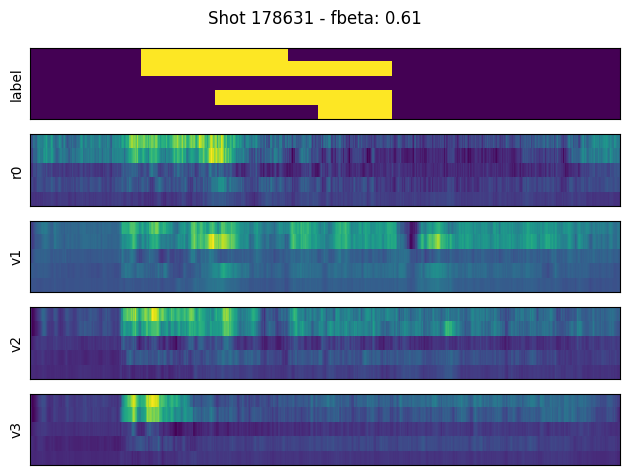

In [9]:
shot_idx = 89

plt.subplot(5,1,1)
plt.imshow(y_train[shot_idx].T, aspect='auto', origin='lower', interpolation='none')
plt.xticks([])
plt.yticks([])
plt.ylabel(f'label')
for diag_idx in range(4):
    plt.subplot(5,1,diag_idx+2)
    plt.imshow(results[shot_idx][diag_idx].T, aspect='auto', origin='lower', interpolation='none')
    results[shot_idx][diag_idx].T.max()
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(f'{diagnostics[diag_idx]}')
plt.suptitle(f'Shot {train_shots[shot_idx]} - fbeta: {scores[:, shot_idx].mean():.2f}')
plt.tight_layout()
plt.show()

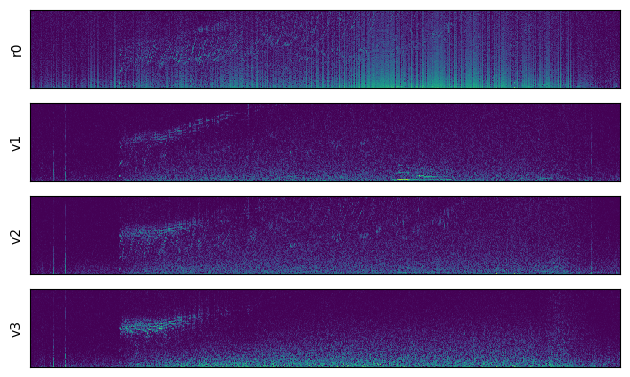

In [79]:
for i, diag in enumerate(diagnostics):
    plt.subplot(5,1,i+2)
    plt.imshow(X_train[shot_idx][diag].T, aspect='auto', origin='lower', interpolation='none')
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(f'{diag}')
plt.tight_layout()
plt.show()

In [ ]:
from dataset import AEEPTS
from specseg.transform import AEEPTransform

In [158]:
spec_params={
    'nfft': 512, # default 1024
    'fs': 500, # raw signal sample rate is 4MHz
    'window': 'hann',
    'scaling': 'density', # {'density', 'spectrum'}
    'detrend': 'linear', # {'linear', 'constant', False}
    }

transform = AEEPTransform(spec_params)
diagnostics = ['r0', 'v1', 'v2', 'v3']

In [159]:
aeepts = AEEPTS(stage='train', diagnostics=diagnostics, transform=transform, window=2000, hop=100, lenshot=2000)

Number windows per shot: 1
Total length of dataset: 120


In [160]:
res_size = [500, 100]
K_in =   [10, -1]  # -1 = Full connection
K_rec = [10, 10]  # -1 = Full connection
insca =  [0.7, 1]
spra =   [1, 0.95]
bisca =  [0.3, 0.5]
leak =    [0.5, 0.1]
regu =   [0.01, 0.01]
nread = aeepts[0][1][0].numpy().T.shape[1]
input_dim = [aeepts[0][0][0].numpy().T.shape[1], nread+aeepts[0][0][0].numpy().T.shape[1]]

W_in = [None] * 2
W_res = [None] * 2
W_bi = [None] * 2
W_out = [None] * 2
x = [None] * 2
o = [None] * 2

bi_dir=False

In [161]:
#### ----- Layer 1 ----- ####
layer =0

W_in[layer], W_res[layer], W_bi[layer] = rcfun.init_weights(input_dim[layer], res_size[layer], K_in[layer], K_rec[layer], insca[layer], spra[layer], bisca[layer])
# W_in[layer] = sparse.csr_matrix(np.hstack([W_in[layer].todense() for x in range(len(inp_feats))]))
# W_in[layer], W_res[layer], W_bi[layer] = rcfun.init_weights(input_dim[layer], res_size[layer], K_in[layer], K_rec[layer], insca[layer], spra[layer], bisca[layer])

t1 = time.time()  # Just to have the time

if bi_dir:

    xTx = np.zeros((2*res_size[layer] + 1, 2*res_size[layer] + 1), dtype='float32')
    xTy = np.zeros((2*res_size[layer] + 1, nread), dtype='float32')
    xlen = 0
else:

    xTx = np.zeros((res_size[layer] + 1, res_size[layer] + 1), dtype='float32')
    xTy = np.zeros((res_size[layer] + 1, nread), dtype='float32')
    xlen = 0   


for i in tqdm(range(len(aeepts))):
    U = aeepts[i][0].numpy()
    d = aeepts[i][1][0].numpy().T
    
    for u in U:

        u = u.T
        x[layer] = rcfun.getX(W_in[layer], W_res[layer], W_bi[layer], leak[layer],bi_dir, u)

        xlen += u.shape[0]
        xTx += np.dot(x[layer].T, x[layer])
        xTy += np.dot(x[layer].T, d)
t2 = time.time()
W_out[layer] = rcfun.res_train(xTx, xTy, xlen, regu[layer])

found (W_in, W_rec, W_bi) > (False, False, False)


100%|██████████| 120/120 [04:26<00:00,  2.22s/it]


In [162]:
#### ----- Layer 2 ----- ####
layer =1
W_in[layer], W_res[layer], W_bi[layer] = rcfun.init_weights(input_dim[layer], res_size[layer], K_in[layer], K_rec[layer], insca[layer], spra[layer], bisca[layer])
t1 = time.time()  # Just to have the time
if bi_dir:

    xTx = np.zeros((2*res_size[layer] + 1, 2*res_size[layer] + 1), dtype='float32')
    xTy = np.zeros((2*res_size[layer] + 1, nread), dtype='float32')
    xlen = 0
else:

    xTx = np.zeros((res_size[layer] + 1, res_size[layer] + 1), dtype='float32')
    xTy = np.zeros((res_size[layer] + 1, nread), dtype='float32')
    xlen = 0 

for i in tqdm(range(len(aeepts))):
    U = aeepts[i][0].numpy()
    d = aeepts[i][1][0].numpy().T
    
    for u in U:

        u = u.T
        x[layer-1] = rcfun.getX(W_in[layer-1], W_res[layer-1], W_bi[layer-1], leak[layer-1],bi_dir, u)
        o[layer-1] = np.dot(x[layer-1], W_out[layer-1])
        x[layer] =   rcfun.getX(W_in[layer], W_res[layer], W_bi[layer], leak[layer], bi_dir, np.hstack([u,o[layer-1]]))

        xlen += u.shape[0]
        xTx += np.dot(x[layer].T, x[layer])
        xTy += np.dot(x[layer].T, d)
t2 = time.time()
W_out[layer] = rcfun.res_train(xTx, xTy, xlen, regu[layer])

t3 = time.time()
print('Exec in %.2f - Train in %.2f sec.!' % (round(t2 - t1, 2), round(t3 - t2, 2)))

found (W_in, W_rec, W_bi) > (False, False, False)


100%|██████████| 120/120 [05:16<00:00,  2.63s/it]

Exec in 316.08 - Train in 0.02 sec.!


In [239]:
weights_file = Path('weights_nathan.pkl')
if weights_file.exists(): print('File already exists, skipping...')
else:
    with open(weights_file, 'wb') as handle:
        pickle.dump([W_in, W_out, W_res, W_bi, leak, bi_dir], handle)

File already exists, skipping...


In [241]:
# load weights
weights_file = Path('weights_nathan.pkl')
if weights_file.is_file() and weights_file.stat().st_size > 0:
    with open(weights_file, 'rb') as handle:
        W_in, W_out, W_res, W_bi, leak, bi_dir = pickle.load(handle)
else:
    raise FileNotFoundError(f"The file {weights_file} does not exist or is empty.")

In [236]:
aeepts = AEEPTS(stage='valid', diagnostics=diagnostics, transform=transform, window=2000, hop=100, lenshot=2000)

Number windows per shot: 1
Total length of dataset: 60


In [242]:
rnd= 170805#np.random.permutation(len(train_shots))[0] #93
# shotn = train_shots[rnd]

feature, label = aeepts.get(rnd,0)
d = label[0].numpy().T

results = []

for i in range(4):
    u = feature[i].numpy().T
    x[0] = rcfun.getX(W_in[0], W_res[0], W_bi[0], leak[0],bi_dir, u)
    o[0] = np.dot(x[0], W_out[0])
    x[1] =   rcfun.getX(W_in[1], W_res[1], W_bi[1], leak[1], bi_dir, np.hstack([u,o[0]]))
    o[1] = np.dot(x[1], W_out[1])
    results.append(o[0])
    
results = np.array(results)

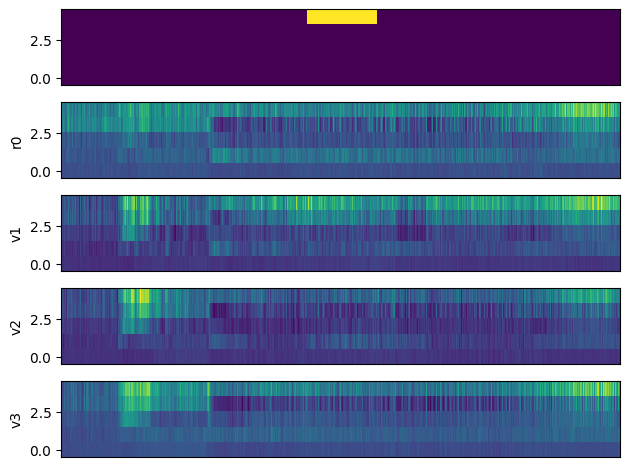

In [243]:
plt.subplot(5,1,1)
plt.imshow(d.T, aspect='auto', origin='lower', interpolation='none')
plt.xticks([])
for i in range(4):
    plt.subplot(5,1,i+2)
    plt.imshow(results[i].T, aspect='auto', origin='lower', interpolation='none')
    plt.xticks([])
    plt.ylabel(f'{diagnostics[i]}')
plt.tight_layout()
plt.show()

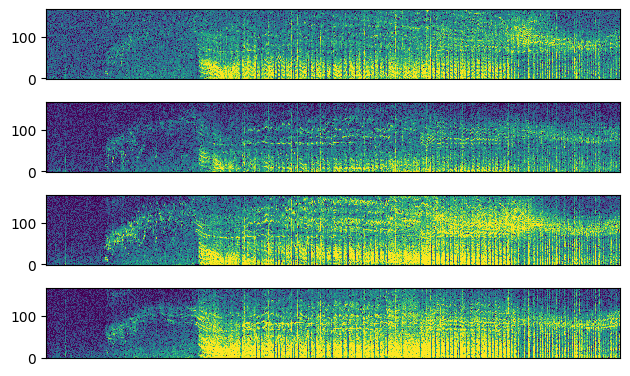

In [244]:
for i in range(4):
    plt.subplot(5,1,i+2)
    plt.imshow(feature[i].numpy(), aspect='auto', origin='lower', interpolation='none')
    plt.xticks([])
plt.tight_layout()
plt.show()